In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import math
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.similarities.docsim import Similarity
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, KFold
from gensim.models import Word2Vec, Doc2Vec
from bs4 import BeautifulSoup
import re
import nltk.data
import string
from gensim.models.doc2vec import TaggedDocument
from gensim import matutils
from sklearn.metrics.pairwise import cosine_similarity
import csv

C:\Users\admin\Anaconda2\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 650 Ti (CNMeM is disabled, cuDNN not available)


In [2]:
iteminfo_train = pd.read_csv('ItemInfo_train.csv')
#iteminfo_test = pd.read_csv('ItemInfo_test.csv')

In [3]:
itempairs_train = pd.read_csv('ItemPairs_train.csv')
#itempairs_test = pd.read_csv('ItemPairs_test.csv')

In [4]:
location = pd.read_csv('Location.csv')
category = pd.read_csv('Category.csv')

In [5]:
iteminfo_train_loc = pd.merge(pd.merge(iteminfo_train, location, how = 'left', on = 'locationID'), category, how = 'left', on = 'categoryID')
#iteminfo_test_loc = pd.merge(pd.merge(iteminfo_test, location, how = 'left', on = 'locationID'), category, how = 'left', on = 'categoryID')

In [6]:
x = pd.merge(pd.merge(itempairs_train, iteminfo_train_loc, how = 'left', left_on = 'itemID_1', right_on = 'itemID'), 
                    iteminfo_train_loc, how = 'left', left_on = 'itemID_2', right_on = 'itemID')
#x_test = pd.merge(pd.merge(itempairs_test, iteminfo_test_loc, how = 'left', left_on = 'itemID_1', right_on = 'itemID'), 
#                    iteminfo_test_loc, how = 'left', left_on = 'itemID_2', right_on = 'itemID')

In [7]:
x['title_x'] = x.title_x.map(lambda x : '' if pd.isnull(x) else x)
x['title_y'] = x.title_y.map(lambda x : '' if pd.isnull(x) else x)
x['description_x'] = x.description_x.map(lambda x : '' if pd.isnull(x) else x)
x['description_y'] = x.description_y.map(lambda x : '' if pd.isnull(x) else x)
#x_test['title_x'] = x_test.title_x.map(lambda x : '' if pd.isnull(x) else x)
#x_test['title_y'] = x_test.title_y.map(lambda x : '' if pd.isnull(x) else x)
#x_test['description_x'] = x_test.description_x.map(lambda x : '' if pd.isnull(x) else x)
#x_test['description_y'] = x_test.description_y.map(lambda x : '' if pd.isnull(x) else x)

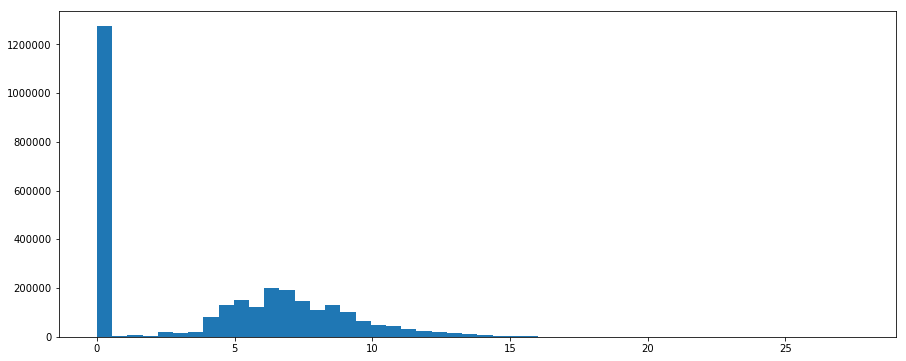

In [8]:
x['price_diff'] = abs(x.price_x - x.price_y).map(lambda x : 0 if np.isnan(x) else 0 if x == 0 else math.log(x))
figure = plt.figure(figsize=(15,6))
plt.hist(x.price_diff, bins = 50)
plt.show()

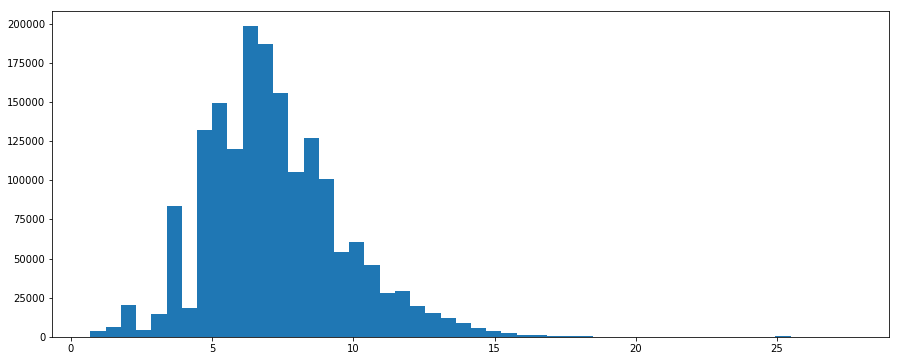

In [9]:
figure = plt.figure(figsize=(15,6))
plt.hist(np.array(x.price_diff)[np.where(x.price_diff != 0)], bins = 50)
plt.show()

## Images
Finding difference in number of images between the two items

In [9]:
x['images_array_x'] =  x['images_array_x'].apply(lambda s : len(s.split()) if isinstance(s, str) else 0)
x['images_array_y'] =  x['images_array_y'].apply(lambda s : len(s.split()) if isinstance(s, str) else 0)
x['images_num_diff'] = x[['images_array_x', 'images_array_y']].apply(lambda s: abs(s[0] - s[1]), axis = 1)

In [19]:
x.groupby('images_num_diff').count()['itemID_1']

images_num_diff
0     1715706
1      699135
2      304168
3      145356
4       81630
5       18942
6        7471
7        5272
8        3632
9        2861
10       3299
11        818
12        770
13        547
14        448
15        353
16        231
17        202
18        152
19        165
20        238
Name: itemID_1, dtype: int64

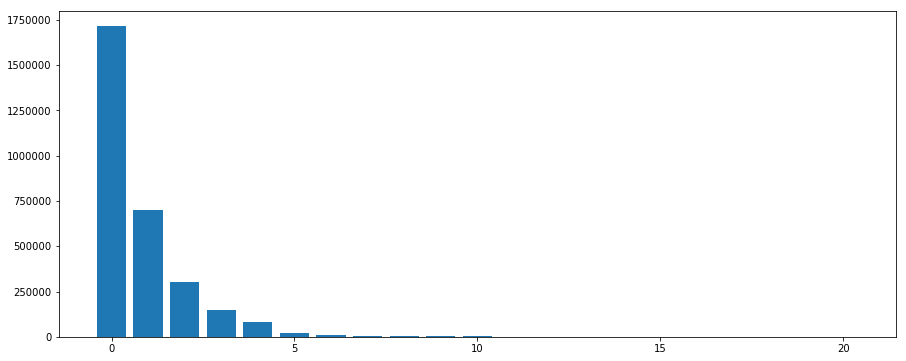

In [20]:
figure = plt.figure(figsize=(15,6))
images_num_diff_counts = x.groupby('images_num_diff').count()['itemID_1']
plt.bar(range(len(images_num_diff_counts)), images_num_diff_counts)
plt.show()

## Computing Similarity

In [10]:
def clean_text(document):    
    # Removes punctuations
    document = document.translate(None, string.punctuation)
    
    # Change to lowercase
    document = document.lower()
    
    # Removes newline characters
    document = ' '.join(document.split('\n'))
    
    # Replace multiple spaces with one space
    document = ' '.join(document.split())
    #document = nlp(unicode(document))
    
    return document

def word_vec(x, model, num_features):
    try:
        a = model[x]
        b = 1
    except KeyError:
        a = np.zeros(num_features)
        b = 0
    return [a,b]

def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0.
    #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    
    for word in words:
        a, b = word_vec(word, model, num_features)
        nwords = nwords + b
        featureVec = np.add(featureVec, a)
    # 
    # Divide the result by the number of words to get the average
    if nwords != 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

In [11]:
# Word2Vec
sentences_desc_x = []
sentences_desc_y = []
for i in range(len(x.description_x)):
    if i in [10, 500000, 1000000, 1500000, 2000000]:
        print i
    sentences_desc_x.append(clean_text(x.description_x[i]))
    sentences_desc_y.append(clean_text(x.description_y[i]))
pd.DataFrame(sentences_desc_x, columns = ['sentences_desc_x']).to_csv('sentences_desc_x.csv')
pd.DataFrame(sentences_desc_y, columns = ['sentences_desc_y']).to_csv('sentences_desc_y.csv')
del sentences_desc_x
del sentences_desc_y

10
500000
1000000
1500000
2000000


In [27]:
sentences_title_x = []
sentences_title_y = []
for i in range(len(x.title_x)):
    if i in [10, 500000, 1000000, 1500000, 2000000]:
        print i
    sentences_title_x.append(clean_text(x.title_x[i]))
    sentences_title_y.append(clean_text(x.title_y[i]))
pd.DataFrame(sentences_title_x, columns = ['sentences_title_x']).to_csv('sentences_title_x.csv')
pd.DataFrame(sentences_title_y, columns = ['sentences_title_y']).to_csv('sentences_title_y.csv')
del sentences_title_x
del sentences_title_y

10
500000
1000000
1500000
2000000


In [26]:
new_x = pd.DataFrame(np.column_stack([x.images_num_diff, x.price_diff, x.parentCategoryID_x, x.isDuplicate]), columns = ['images_num_diff', 'price_diff', 'parentCategoryID_x', 'isDuplicate'])
new_x.to_csv('new_x.csv')
del new_x

In [11]:
sentences_desc_x = pd.read_csv('sentences_desc_x.csv')
sentences_desc_y = pd.read_csv('sentences_desc_y.csv')
sentences_title_x = pd.read_csv('sentences_title_x.csv')
sentences_title_y = pd.read_csv('sentences_title_y.csv')
x = pd.read_csv('new_x.csv')

In [12]:
del sentences_desc_x['Unnamed: 0']
del sentences_desc_y['Unnamed: 0']
del sentences_title_x['Unnamed: 0']
del sentences_title_y['Unnamed: 0']
del x['Unnamed: 0']

In [13]:
kf = KFold(n_splits = 5, random_state = 1)
train_score = []
test_score = []
log_reg = LogisticRegression()
i = 0
sentences_desc_x = np.array(sentences_desc_x.sentences_desc_x.map(lambda x : x.split() if isinstance(x, basestring) else str(x)))
sentences_desc_y = np.array(sentences_desc_y.sentences_desc_y.map(lambda x : x.split() if isinstance(x, basestring) else str(x)))
sentences_title_x = np.array(sentences_title_x.sentences_title_x.map(lambda x : x.split() if isinstance(x, basestring) else str(x)))
sentences_title_y = np.array(sentences_title_y.sentences_title_y.map(lambda x : x.split() if isinstance(x, basestring) else str(x)))


w2v_x
w2v_y
w2v_x
w2v_y
cos_sim_x
Test Accuracy: 0.668372668316
Train Accuracy: 0.66837420334


AttributeError: 'numpy.ndarray' object has no attribute 'sentences_desc_x'

In [ ]:
for train_index, test_index in kf.split(x):
    sentences_desc_x_train = sentences_desc_x[train_index].tolist()
    sentences_desc_y_train = sentences_desc_y[train_index].tolist()
    sentences_desc_x_test = sentences_desc_x[test_index].tolist()
    sentences_desc_y_test = sentences_desc_y[test_index].tolist()
    sentences_title_x_train = sentences_title_x[train_index].tolist()
    sentences_title_y_train = sentences_title_y[train_index].tolist()
    sentences_title_x_test = sentences_title_x[test_index].tolist()
    sentences_title_y_test = sentences_title_y[test_index].tolist()
    print 'w2v_x'
    model_desc_x = Word2Vec(sentences_desc_x_train, min_count = 1, size = 50)
    model_desc_x.save('model_desc_x')
    print 'w2v_y'
    model_desc_y = Word2Vec(sentences_desc_y_train, min_count = 1, size = 50)
    model_desc_y.save('model_desc_x')
    print 'w2v_x'
    model_title_x = Word2Vec(sentences_title_x_train, min_count = 1, size = 50)
    model_title_x.save('model_desc_x')
    print 'w2v_y'
    model_title_y = Word2Vec(sentences_title_y_train, min_count = 1, size = 50)
    model_title_y.save('model_desc_x')
    print 'cos_sim_x'
    x_train, x_test = x.loc[train_index, :], x.loc[test_index, :]
    cos_sim_desc_train = []
    cos_sim_desc_test = []
    num_features = model_desc_x.wv.syn0.shape[1]
    ofile = open('C:\\Users\\admin\Desktop\\Training\\Avito\\cos_sim_desc_train.csv', 'wb')
    writer = csv.writer(ofile)
    writer.writerow(['cos_sim_desc_train'])
    cos_sim_desc_train = []
    for i in range(len(sentences_desc_x_train)):
        cos_sim = cosine_similarity(np.array([makeFeatureVec(sentences_desc_x_train[i], model_desc_x, num_features),
                                                        makeFeatureVec(sentences_desc_y_train[i], model_desc_y, num_features)]))[1, 0]
        cos_sim_desc_train.append(cos_sim)
        writer.writerow([cos_sim])
    ofile.close()
    ofile = open('C:\\Users\\admin\Desktop\\Training\\Avito\\cos_sim_desc_test.csv', 'wb')
    writer = csv.writer(ofile)
    writer.writerow(['cos_sim_desc_test'])
    for i in range(len(sentences_desc_x_test)):
        cos_sim = cosine_similarity(np.array([makeFeatureVec(sentences_desc_x_test[i], model_desc_x, num_features),
                                                        makeFeatureVec(sentences_desc_y_test[i], model_desc_y, num_features)]))[1, 0]
        writer.writerow([cos_sim])
        cos_sim_desc_test.append(cos_sim)
    ofile.close()
    
    cos_sim_title_train = []
    cos_sim_title_test = []
    num_features = model_desc_x.wv.syn0.shape[1]
    ofile = open('C:\\Users\\admin\Desktop\\Training\\Avito\\cos_sim_title_train.csv', 'wb')
    writer = csv.writer(ofile)
    writer.writerow(['cos_sim_title_train'])
    for i in range(len(sentences_title_x_train)):
        cos_sim = cosine_similarity(np.array([makeFeatureVec(sentences_title_x_train[i], model_title_x, num_features),
                                                        makeFeatureVec(sentences_title_y_train[i], model_title_y, num_features)]))[1, 0]
        writer.writerow([cos_sim])
        cos_sim_title_train.append(cos_sim)

    ofile.close()
    ofile = open('C:\\Users\\admin\Desktop\\Training\\Avito\\cos_sim_title_test.csv', 'wb')
    writer = csv.writer(ofile)
    writer.writerow(['cos_sim_title_test'])
    for i in range(len(sentences_desc_x_test)):
        cos_sim = cosine_similarity(np.array([makeFeatureVec(sentences_title_x_test[i], model_title_x, num_features),
                                                        makeFeatureVec(sentences_title_y_test[i], model_title_y, num_features)]))[1, 0]
        writer.writerow([cos_sim])
        cos_sim_title_test.append(cos_sim)
    ofile.close()
    
    #pd.DataFrame(cos_sim_desc_train).to_csv('cos_sim_desc_train' + str(i) + '.csv')
    #pd.DataFrame(cos_sim_desc_train).to_csv('cos_sim_desc_test' + str(i) + '.csv')
    #pd.DataFrame(cos_sim_desc_train).to_csv('cos_sim_title_train' + str(i) + '.csv')
    #pd.DataFrame(cos_sim_desc_train).to_csv('cos_sim_title_test' + str(i) + '.csv')
    i = i + 1
    train_x_full = pd.DataFrame(np.column_stack([cos_sim_desc_train, cos_sim_title_train, x_train.price_diff, x_train.images_num_diff, x_train.parentCategoryID_x]))
    train_x_full.to_csv('train_x_full.csv')
    test_x_full = pd.DataFrame(np.column_stack([cos_sim_desc_test, cos_sim_title_test, x_test.price_diff, x_test.images_num_diff, x_test.parentCategoryID_x]))
    test_x_full.to_csv('test_x_full.csv')
    log_reg.fit(train_x_full, np.array(x_train.isDuplicate))
    pred_train = log_reg.predict(train_x_full)
    pred_test = log_reg.predict(test_x_full)
    train_score.append(pred_train)
    test_score.append(pred_test)
    print "Test Accuracy:", accuracy_score(x_test.isDuplicate, pred_test)
    print "Train Accuracy:", accuracy_score(x_train.isDuplicate, pred_train)

w2v_x
w2v_y
w2v_x
w2v_y
cos_sim_x
Test Accuracy: 0.66829578124
Train Accuracy: 0.668328656028
w2v_x
w2v_y
w2v_x
w2v_y
cos_sim_x
Test Accuracy: 0.668286869504
Train Accuracy: 0.668633418257
w2v_x
w2v_y
w2v_x
w2v_y
cos_sim_x


In [29]:
del sentences_desc_x 
del sentences_desc_y 
del sentences_title_x 
del sentences_title_y 
del sentences_desc_x_train
del sentences_desc_y_train
del sentences_desc_x_test 
del sentences_desc_y_test 
del sentences_title_x_train
del sentences_title_y_train
del sentences_title_x_test 
del sentences_title_y_test 

In [25]:
for i in range(100):
    if cosine_similarity(np.array([makeFeatureVec(sentences_desc_x_train[i], model_title_x, num_features),
                                                        makeFeatureVec(sentences_desc_x_train[i], model_title_y, num_features)]))[1, 0] == 0:
        print i

81
